In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using Distributions 
using IntervalSets
using BAT

using HCubature
using JLD2
using CPUTime
using LaTeXStrings
using SpecialFunctions
using KernelDensity

# using Plots
# using Colors
# using ColorSchemes
# pyplot(size=(750,500))
# line_colors = ColorSchemes.tab20b;

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1260


In [2]:
using Plots

In [3]:
using PyPlot

In [4]:
# using BATPar
# using KDTree
# include("plotting recipes.jl")

# Generate Distribution: 

In [5]:
"""
    randcormatrix(d, η)
Generate a d-by-d random correlation matrix using the
method described in:
    Lewandowski, Kurowicka, Joe
      "Generating random correlation matrices based on vines
        and extended onion method"
    Journal of Multivariate Analysis 100 (2009)
    doi:10.1016/j.jmva.2009.04.008
"""
function randcormatrix(d, η)
    β = η + (d - 2) / 2
    u = rand(Distributions.Beta(β, β))
    r₁₂ = 2 * u - 1
    r = [   1 r₁₂ ;
          r₁₂   1 ]
    # In published paper this index is n = 2:d-1. n is never mentioned
    # again, but a mysterious k is, so we'll thus use k. A similar approach
    # was taken here: http://stats.stackexchange.com/a/125017/58921
    for k in 2:d - 1
        β = β - 1 / 2
        y = rand(Distributions.Beta(k / 2, β))
        u = randn(k)
        u /= norm(u)
        w = sqrt(y) * u
        A = cholesky(r).L
        z = A * w
        r = [ r  z ;
              z' 1 ]
    end
    return r
end

"""
    randcovmatrix(d, η, σ)
Use randcormatrix with desired vector of standard deviations σ
for each term to generate a random covariance matrix.
"""
function randcovmatrix(d, η, σ)
    length(σ) != d && throw(DimensionMismatch("length(σ) doesn't match d"))
    r = randcormatrix(d, η)
    Σ = zeros(d, d)
    @inbounds for i in 1:d, j in 1:d
        Σ[i,j] = r[i,j] * σ[i] * σ[j]
    end
    return Σ
end

randcovmatrix

In [15]:
n_clusters = 5
n_dims = 4
low=-10
high=10
η = .2

means = rand(Uniform(low,high), n_clusters, n_dims)
sigma = rand(Uniform(1,(high-low)/2), n_dims)
cov_m = zeros(n_clusters, n_dims, n_dims)

for i in 1:size(cov_m)[1]
#     cov_m[i,:,:] .= randcovmatrix(n_dims, η, sigma)
    η = rand(Uniform(0.1,0.4), 1)[1]
    cov_m[i,:,:] .= randcovmatrix(n_dims, η, sigma)
end

In [21]:
# JLD2.@save "../data/mixture-4D.jld" means cov_m n_clusters

In [17]:
model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);

In [18]:
iid_distributions = NamedTupleDist(a = model,)
samples_iid = bat_sample(iid_distributions, 10^6).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm RandSampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


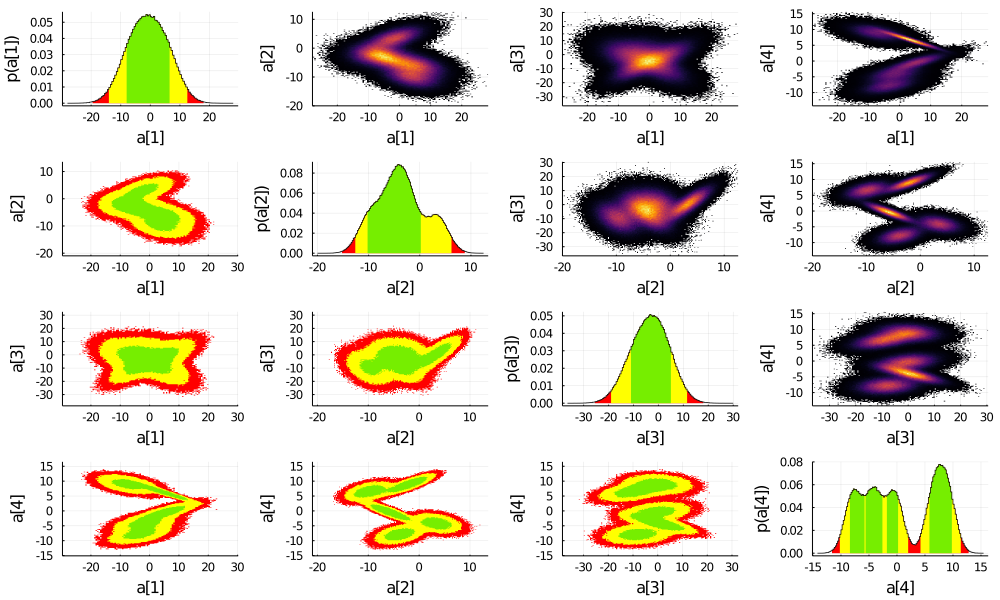

In [19]:
Plots.plot(samples_iid, vsel=[1,2,3,4,5])

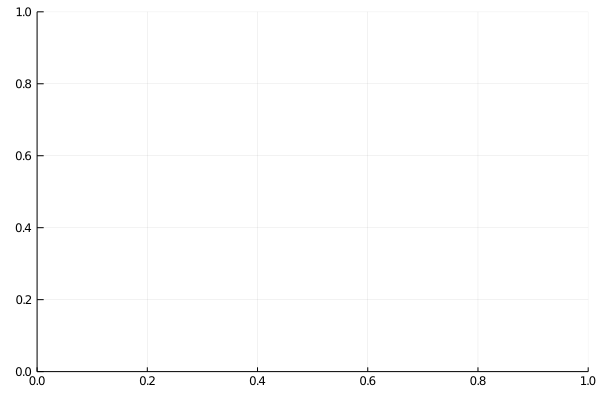

In [20]:
Plots.plot(samples_iid, vsel=[6,7,8,9,10])